# Exercise in obtaining and plotting CMIP6 climate model results

Much content borrowed from [Google CoLab demo](https://colab.research.google.com/drive/1B7gFBSr0eoZ5IbsA0lY8q3XL8n-3BOn4#scrollTo=-83tcwHa3O3u).  See NSF [using intake-esm](https://intake-esm.readthedocs.io/en/v2021.8.17/user-guide/cmip6-tutorial.html) for non-FSMap solution.  Both require Zarray v. 2.x, and fail with Zarray 3+.  N.B. a possible solution is to [require a specific version of Zarray](https://stackoverflow.com/questions/6445167/force-python-to-use-an-older-version-of-module-than-what-i-have-installed-now) during import.  This script works with Zarr v. 2.18.4, and apparently with Zarr v. 3+ as well.

This Notebook is licensed for free and open consumption under the [Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)](https://creativecommons.org/licenses/by-nc/4.0/) license.

CVS: $Id: AccessCMIP6results.ipynb,v 25.5 2025/03/24 21:36:34 brikowi Exp $

In [14]:
# Load needed packages
import glob                        # Search by pattern for files or directories
import matplotlib.pyplot as plt    # Standard plotting package for Python
import urllib.request              # Download files given a URL
# Large array handling
import numpy as np
import xarray as xr
xr.set_options(display_style='html')
import gcsfs                        # Google cloud file system

In [15]:
import pandas as pd                 # Array management as dataframes
import datetime                     # Date-time manipulation routines
import os                           # Operating system routines (good way to make notebook OS-independent)

# Identify available files in Google Cloud, Obtain desired dataset(s)

Get list of CMIP6 files available at Google, save it in a Pandas dataframe (*df*).  Pandas dataframes are just tables with named columns (and potentially named rows).  See a general introduction at [Panda's in 10 minutes](https://pandas.pydata.org/docs/user_guide/10min.html).  Good "general" summary at [CMIP6 data users guide](https://pcmdi.llnl.gov/CMIP6/Guide/dataUsers.html).

In [16]:
%%time
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

CPU times: total: 1.41 s
Wall time: 2.38 s


In [17]:
print(f"There are currently {(len(df)-1):,} model output files in the Google database.  Here are the first five:")
df.head()

There are currently 523,773 model output files in the Google database.  Here are the first five:


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


## Narrow the selection of models

Lets narrow the choices.  See the [CMIP model vocabulary](https://github.com/WCRP-CMIP/CMIP6_CVs) for detailed explanation of choices, or [CMIP6 Data Request](https://clipc-services.ceda.ac.uk/dreq/tab01_3_3.html) webpage for choices organized as tables.

* activity_id = ScenarioMIP, models of various SSP emissions scenarios (Fig. 4 of model_types.pdf lecture notes)
* variable_id = surface air temperature (*'tas'*).  See full list at [LLNL](https://pcmdi.llnl.gov/mips/cmip3/variableList.html)
* experiment_id = *ssp585* (worst case warming) or *historical* scenarios.  Search for experiments at [CMIP6 GitHub](https://wcrp-cmip.github.io/CMIP6_CVs/docs/CMIP6_experiment_id.html)
* table_id = monthly atmospheric variables (Amon, all we'll need for this class;  see summary at [CMIP6 ScenarioMIP Data Request](https://clipc-services.ceda.ac.uk/dreq/tabs03/expt_CMIP_ScenarioMIP_3_3.html)
* member_id = "r1i1p1f1".  [Four indices defining an ensemble member](https://pcmdi.llnl.gov/CMIP6/Guide/dataUsers.html): “r” for realization, “i” for initialization, “p” for physics, and “f” for forcing.  We want same for all models we will compare.

In [18]:
df_ssp585 = df.query("activity_id=='ScenarioMIP' & table_id == 'Amon' & " +\
    "variable_id == 'tas' & experiment_id == 'ssp585' & member_id == 'r1i1p1f1'")
print(f'{len(df_ssp585)} models fit these criteria.  Here are the first 3 (in dataframe df_ssp585):')
df_ssp585.head(3)

35 models fit these criteria.  Here are the first 3 (in dataframe df_ssp585):


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
866,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp585,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM...,NaN,20180701
19008,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp585,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701
66586,ScenarioMIP,BCC,BCC-CSM2-MR,ssp585,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/BCC/BCC-CSM2-MR/s...,NaN,20190314


### Check for duplicate models

In [19]:
print ('Source models in df_ssp585: ', df_ssp585.source_id.unique())
print('There are %4d unique source models in df_ssp585' % len(df_ssp585.source_id.unique()))

Source models in df_ssp585:  ['GFDL-CM4' 'GFDL-ESM4' 'BCC-CSM2-MR' 'CanESM5' 'AWI-CM-1-1-MR'
 'INM-CM4-8' 'MIROC6' 'CAMS-CSM1-0' 'MPI-ESM1-2-LR' 'MPI-ESM1-2-HR'
 'INM-CM5-0' 'NESM3' 'FGOALS-g3' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'FGOALS-f3-L'
 'MRI-ESM2-0' 'NorESM2-LM' 'NorESM2-MM' 'FIO-ESM-2-0' 'EC-Earth3-Veg'
 'EC-Earth3' 'CIESM' 'CMCC-CM2-SR5' 'CESM2-WACCM' 'TaiESM1' 'IITM-ESM'
 'E3SM-1-1' 'EC-Earth3-Veg-LR' 'CAS-ESM2-0' 'EC-Earth3-CC' 'CMCC-ESM2'
 'ACCESS-CM2' 'ACCESS-ESM1-5' 'KIOST-ESM']
There are   35 unique source models in df_ssp585


### Get historical model results

These will be used to see how well the models match recorded climate (usually 1900-2000).

In [20]:
df_historical = df.query("activity_id == 'CMIP' & table_id == 'Amon' & " +\
    "variable_id == 'tas' & experiment_id == 'historical' & member_id == 'r1i1p1f1'")
print('Length of df_historical:', len(df_historical))
df_historical.head(3)

Length of df_historical: 55


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
8074,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
29231,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
32351,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...,NaN,20180827


# Select desired model and download data

## Set parameters for desired model

In [24]:
model = 'GFDL-CM4'
zstore_hist = df_historical.query(f"source_id == '{model}'").zstore.values[0]
zstore_ssp585 = df_ssp585.query(f"source_id == '{model}'").zstore.values[0]
import gcsfs
gcs = gcsfs.GCSFileSystem(token='anon')

## Download *zarr* descriptions for the *historic* and *ssp585* models.  
These files were originally NetCDF format 'monolithic' files, stored in *zarr* format at Google.  This format allows download of smaller "chunks" of only the needed data from these files (e.g. for a region of interest).  The descriptions allow determination of which chunks are needed.

**Fixing error** *TypeError: Unsupported type for store_like: 'FSMap'*: if you get an error (red-background output) with this error at the bottom of the output, update your *geoClimate* conda environment by issuing the command *"conda install -c conda-forge intake-esm"* while in the geoClimate environment.

**Debugging/Version info** :  with zarr v. 3+ the generated FSMap file type isn't allowed and xr.open_zarr fails.  See [Zarr GitHub 'feature' discussion](https://github.com/zarr-developers/zarr-python/issues/2706).  "Load Data" framework from [Pangeo Google Cloud CMIP6 Public Data: Basic Python Example](https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/basic_search_and_load.html) suffers from same problem.  Far more promising is [CMIP6 Dataset Access Made Easy: No Downloads Necessary](https://medium.com/@harismushtaq021/cmip6-dataset-access-made-easy-no-downloads-necessary-7e62976306d3), which uses (intake-esm module)[https://intake-esm.readthedocs.io/en/stable/tutorials/loading-cmip6-data.html], which requires zarray v. 2.*.  So choice of approach arbitrary for now, since all choices use deprecated version of Zarray.

In [25]:
%%time
# This method works for zarr v. 3+, previous code using gcs.get_mapper would also work for zarr v. 3+ younger than 3/15/25
# based on comments at https://github.com/zarr-developers/zarr-python/issues/2706
ds_hist = xr.open_zarr(zstore_hist, consolidated = True)
ds_ssp585 = xr.open_zarr(zstore_ssp585, consolidated = True)

KeyError: 'content-type'

In [26]:
import fsspec
import xarray as xr

model = 'GFDL-CM4'

zstore_hist = df_historical.query(f"source_id == '{model}'").zstore.values[0]
zstore_ssp585 = df_ssp585.query(f"source_id == '{model}'").zstore.values[0]

# 🔧 Use fsspec directly to enforce anonymous access
mapper_hist = fsspec.get_mapper(zstore_hist, anon=True)
mapper_ssp = fsspec.get_mapper(zstore_ssp585, anon=True)

# ✅ Load the Zarr datasets
ds_hist = xr.open_zarr(mapper_hist, consolidated=True)
ds_ssp585 = xr.open_zarr(mapper_ssp, consolidated=True)


## Show internal details of the downloaded files.  
*bnds* are the location of cell edges, *lat-lon-time* are the centers of each cell.  There are 180x288x1980= **102,643,200 16-digit values in the *tas* array**

In [27]:
ds_hist

<xarray.Dataset> Size: 411MB
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 1980)
Coordinates:
  * bnds       (bnds) float64 16B 1.0 2.0
    height     float64 8B ...
  * lat        (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 3kB dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 2kB 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
    lon_bnds   (lon, bnds) float64 5kB dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, bnds) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
Data variables:
    tas        (time, lat, lon) float32 411MB dask.array<chunksize=(600, 180, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36500.0
    comment:                <null ref>
    ...                     ...
    variable_id:            tas
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-08-07;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/e4193a02-6405-49b6-8ad3-65def741a4dd...
    version_id:             v20180701

## Assess date ranges of both arrays

Check the date ranges.  Note use of subscript "-1" as shorthand for last entry in array.

In [28]:
print('hist date range  :', ds_hist.time[0].values, ' , ', ds_hist.time[-1].values)
print('ssp585 date range:', ds_ssp585.time[0].values, ' , ', ds_ssp585.time[-1].values)

hist date range  : 1850-01-16 12:00:00  ,  2014-12-16 12:00:00
ssp585 date range: 2015-01-16 12:00:00  ,  2100-12-16 12:00:00


## Adjust times for ease in plotting, set plot date ranges

Set day for monthly data to the 15th.  This is consistent with U.S. Climate Explorer dates for downloaded monthly data.

In [29]:
# Adjust times to be consistent
start_time = pd.to_datetime(datetime.date(1850,1,15)) # I chose 15 for all dates to make it easier.
time_new_hist = [start_time + pd.DateOffset(months = x) for x in range(len(ds_hist.time))]


### Select date ranges for plotting 

Plot 1980-2010 (historic range for US Climate Explorer) and 2070-2099

In [30]:
# Select desired time ranges for plotting 
start_time = pd.to_datetime(datetime.date(2015,1,15))
time_new_ssp585 = [start_time + pd.DateOffset(months = x) for x in range(len(ds_ssp585.time))]
ds_hist = ds_hist.assign_coords(time = time_new_hist)
ds_ssp585 = ds_ssp585.assign_coords(time = time_new_ssp585)
start_date = pd.to_datetime(datetime.date(1980,1,1))
end_date = pd.to_datetime(datetime.date(2010,12,31))
ds_hist_sel = ds_hist.isel(time=(ds_hist.time >= start_date) & (ds_hist.time <= end_date))

start_date = pd.to_datetime(datetime.date(2070,1,1))
end_date = pd.to_datetime(datetime.date(2099,12,31))
ds_ssp585_sel = ds_ssp585.isel(time=(ds_ssp585.time >= start_date) & (ds_ssp585.time <= end_date))

## Downloaded selected datasets

Historical and SSP5 8.5 (worst case scenario), model GFDL-CM4 for the two date ranges only.

In [31]:
%%time
# Download selected datasets, store in memory
ds_hist_sel.load()
ds_ssp585_sel.load()

CPU times: total: 2.09 s
Wall time: 4.03 s


<xarray.Dataset> Size: 75MB
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 360)
Coordinates:
  * bnds       (bnds) float64 16B 1.0 2.0
    height     float64 8B 2.0
  * lat        (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 3kB -90.0 -89.0 -89.0 ... 89.0 89.0 90.0
  * lon        (lon) float64 2kB 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
    lon_bnds   (lon, bnds) float64 5kB 0.0 1.25 1.25 2.5 ... 358.8 358.8 360.0
    time_bnds  (time, bnds) object 6kB 2070-01-01 00:00:00 ... 2100-01-01 00:...
  * time       (time) datetime64[ns] 3kB 2070-01-15 2070-02-15 ... 2099-12-15
Data variables:
    tas        (time, lat, lon) float32 75MB 242.4 242.4 242.4 ... 269.6 269.6
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  60225.0
    comment:                <null ref>
    ...                     ...
    variable_id:            tas
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-08-13;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/991bc4a4-20d5-4a58-a451-6b3ea33116be
    version_id:             v20180701

# Plot mean temperature change, recent historical to end of worst-case model

Note that temporal averages are computed easily using the Pandas [groupby](https://www.geeksforgeeks.org/python-pandas-dataframe-groupby/) facility.

In [32]:
# Compute mean monthly temperature
tas_avg_hist = ds_hist_sel.groupby('time.month').mean()
tas_avg_ssp585 = ds_ssp585_sel.groupby('time.month').mean()

## Review new time axis

Note the *time* dimension is now *month*, averaged over the period 2070-2099 for the *ssp585* dataset, so a 30 year average for each month.  This smooths out model variability over individual years.

In [33]:
tas_avg_ssp585

<xarray.Dataset> Size: 2MB
Dimensions:   (month: 12, lat: 180, lon: 288, bnds: 2)
Coordinates:
  * bnds      (bnds) float64 16B 1.0 2.0
    height    float64 8B 2.0
  * lat       (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds  (lat, bnds) float64 3kB -90.0 -89.0 -89.0 -88.0 ... 89.0 89.0 90.0
  * lon       (lon) float64 2kB 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
    lon_bnds  (lon, bnds) float64 5kB 0.0 1.25 1.25 2.5 ... 358.8 358.8 360.0
  * month     (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    tas       (month, lat, lon) float32 2MB 246.6 246.6 246.6 ... 265.6 265.6
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  60225.0
    comment:                <null ref>
    ...                     ...
    variable_id:            tas
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-08-13;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/991bc4a4-20d5-4a58-a451-6b3ea33116be
    version_id:             v20180701

## Compute future departure from historical average

Difference in monthly temperatures between historical (1980-2010) and worst-case future (ssp585) 2070-2099 for this model.

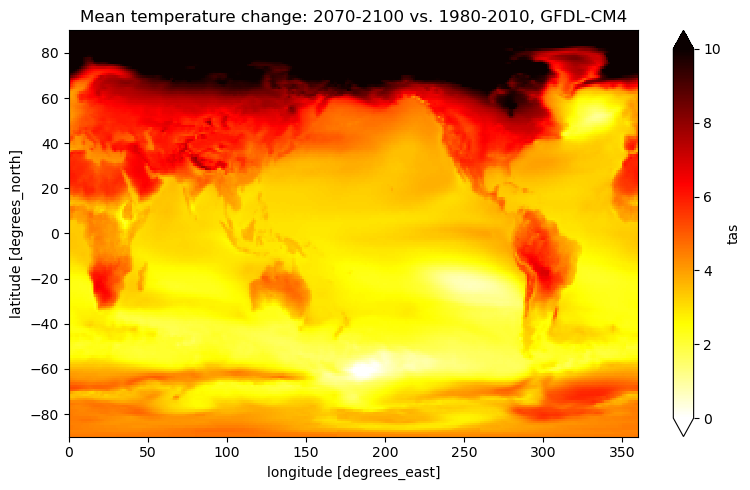

In [34]:
# Compute departure from historical monthly average
tas_30yr_diff = tas_avg_ssp585 - tas_avg_hist
# Plot average of departures
tas_30yr_diff.mean('month').tas.plot(figsize=[8,5], cmap = 'hot_r', 
                                     vmin = 0, vmax = 10)
plt.title(f'Mean temperature change: 2070-2100 vs. 1980-2010, {model}')
plt.tight_layout()

## Plot with continental outlines
Using package *cartopy*.  See [Python geographic visualization tutorial](https://fmichonneau.github.io/python-aos-lesson/02-visualisation/index.html).  Here we take the title and colorbar units from attributes of the dataset.

C:\Users\gargi\anaconda3\envs\geoClimate\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


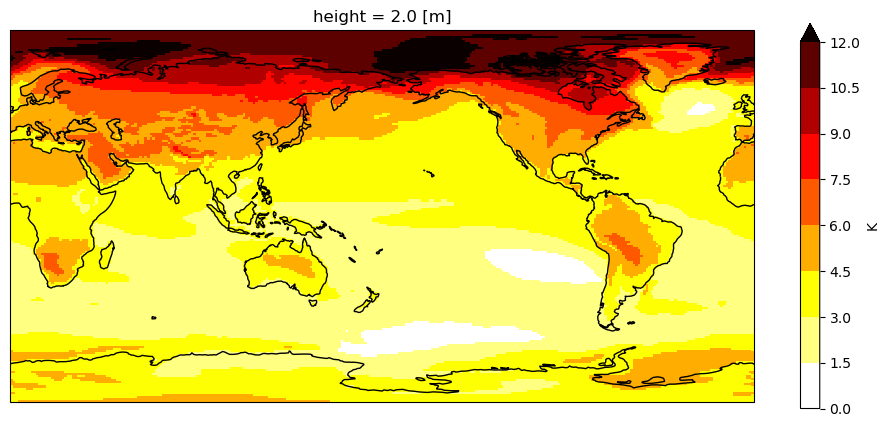

In [35]:
import cartopy.crs as ccrs
clim = tas_avg_hist['tas']
fig = plt.figure(figsize=[12,5])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
tas_30yr_diff.mean('month').tas.plot(ax=ax,
                   levels=np.arange(0, 13.5, 1.5),
                   extend='max',
                   transform=ccrs.PlateCarree(),
                   add_colorbar=True,                        
                   cbar_kwargs={'label': tas_avg_hist.tas.units},
                   cmap='hot_r')
ax.coastlines()

# Plot parameter vs. time for an area/location

In [37]:
left = 360 - 75.0   # ≈ 285.0
right = 360 - 73.0  # ≈ 287.0
bottom = 40.0
top = 41.5


### Take geographic subset and average

Note we are subsetting the original 30-year datasets (ds_hist_sel & ds_ssp585_sel).

In [38]:
# Subset data by that lat-long box, take average over lat-long, ignore other variables
tas_NW_yr_hist = ds_hist_sel.isel(lat = (ds_hist_sel.lat>=bottom) & (ds_hist_sel.lat<=top),
                   lon = (ds_hist_sel.lon>=left) & (ds_hist_sel.lon<=right),
                   ).mean(['lat','lon']).drop_vars(['bnds', 'height', 'time_bnds'])
tas_NW_yr_ssp585 = ds_ssp585_sel.isel(lat = (ds_ssp585_sel.lat>=bottom) & (ds_ssp585_sel.lat<=top),
                   lon = (ds_ssp585_sel.lon>=left) & (ds_ssp585_sel.lon<=right),
                   ).mean(['lat','lon']).drop_vars(['bnds', 'height', 'time_bnds'])


## View structure of timeseries dataset

Now the only coordinate is *time*, since we've averaged over latitude and longitude using mean(['lat','lon']).

In [39]:
tas_NW_yr_ssp585

<xarray.Dataset> Size: 4kB
Dimensions:  (time: 360)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2070-01-15 2070-02-15 ... 2099-12-15
Data variables:
    tas      (time) float32 1kB 274.1 279.1 278.1 285.4 ... 290.9 286.2 281.2

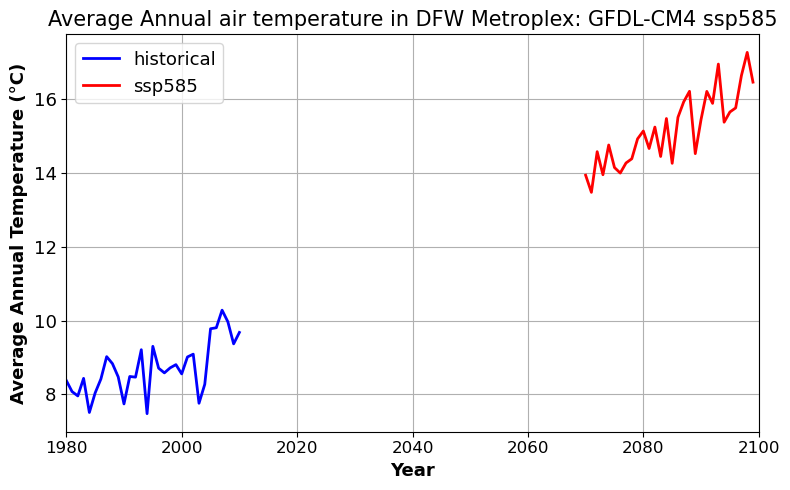

In [40]:
# Plot the timeseries
plt.figure(figsize=[8,5],)
(tas_NW_yr_hist.groupby('time.year').mean().tas-273.15).plot(
    label='historical', color='b', linewidth=2)
(tas_NW_yr_ssp585.groupby('time.year').mean().tas-273.15).plot(
    label='ssp585', color='r', linewidth=2)
plt.grid()
plt.xlim([1980,2100])
plt.legend(fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=13)
plt.ylabel('Average Annual Temperature (°C)', fontsize=13, fontweight='bold')
plt.xlabel('Year', fontsize=13, fontweight='bold')
plt.title(f'Average Annual air temperature in DFW Metroplex: {model} ssp585',
          fontsize=15)

plt.tight_layout()

# Export data

Collect results for all years over specified lat-long box (DFW in this example)

In [41]:
# Collect results for all years
tasLocYrAll = ds_hist.isel(lat = (ds_hist.lat>=bottom) & (ds_hist.lat<=top),
                   lon = (ds_hist.lon>=left) & (ds_hist.lon<=right),
                   ).mean(['lat','lon']).drop_vars(['bnds', 'height', 'time_bnds'])

In [75]:
tasLocYrFuture = ds_ssp585.sel(
    lat=(ds_ssp585.lat>=bottom) & (ds_ssp585.lat<=top),
    lon=(ds_ssp585.lon>=left) & (ds_ssp585.lon<=right)
).mean(['lat','lon']).drop_vars(['bnds', 'height', 'time_bnds'])


## Review spatially-averaged dataset

Now only a temporal dimension *date*.  To be used for comparison with US Climate Explorer output.

In [42]:
tasLocYrAll

<xarray.Dataset> Size: 24kB
Dimensions:  (time: 1980)
Coordinates:
  * time     (time) datetime64[ns] 16kB 1850-01-15 1850-02-15 ... 2014-12-15
Data variables:
    tas      (time) float32 8kB dask.array<chunksize=(600,), meta=np.ndarray>

## Average by year, export to CSV file
Save TAS to CSV file (as centigrade), averaged by year for comparison with US Climate Explorer output.

In [44]:
%%time
hist4export = (tasLocYrAll.groupby('time.year').mean().tas-273.15)
tempDF = hist4export.to_dataframe()
tempDF.to_csv('NYCHistoricalTASMAX_GFDL-CM4.csv')

CPU times: total: 2.83 s
Wall time: 4.66 s


In [77]:
future4export = (tasLocYrFuture.groupby("time.year").mean().tas - 273.15)
futureDF = future4export.to_dataframe()
futureDF.to_csv("NYCFutureTASMAX_GFDL-CM4.csv")


In [45]:
import pandas as pd
import os

# List of your CSV files (you can adjust the filenames if needed)
file_list = [
    'NYCHistoricalTASMAX_GFDL-CM4.csv',
    'New_York_County-annual-proj_mod-tmax.csv',
    'New_York_County-annual-proj_mod-pcpn.csv',
    'New_York_County-annual-hist_obs-tmax.csv',
    'New_York_County-annual-hist_obs-pcpn.csv',
    'New_York_County-annual-hist_mod-tmax.csv',
    'New_York_County-annual-hist_mod-pcpn.csv'
]

# Loop through and display basic info
for filename in file_list:
    print(f"\n📄 File: {filename}")
    
    try:
        df = pd.read_csv(filename)
        print("🔹 Columns:", list(df.columns))
        print("🔹 First 5 rows:")
        display(df.head())
    except Exception as e:
        print(f"⚠️ Could not read {filename}: {e}")



📄 File: NYCHistoricalTASMAX_GFDL-CM4.csv
🔹 Columns: ['year', 'tas']
🔹 First 5 rows:


,year,tas
0,1850,8.954041
1,1851,7.966187
2,1852,7.233063
3,1853,8.889832
4,1854,8.717133



📄 File: New_York_County-annual-proj_mod-tmax.csv
🔹 Columns: ['year', ' rcp45_weighted_mean', ' rcp45_min', ' rcp45_max', ' rcp85_weighted_mean', ' rcp85_min', ' rcp85_max', ' NOTE: This file contains annual projection values produced by global climate models. Decadal averages of these values (as shown in the Climate Explorer) are a more appropriate temporal scale for using projections.']
🔹 First 5 rows:


,year,rcp45_weighted_mean,rcp45_min,rcp45_max,rcp85_weighted_mean,rcp85_min,rcp85_max,NOTE: This file contains annual projection values produced by global climate models. Decadal averages of these values (as shown in the Climate Explorer) are a more appropriate temporal scale for using projections.
0,2005,63.6,59.9,66.1,63.6,59.9,66.1,NaN
1,2006,63.5,59.9,66.7,63.5,60.9,65.4,NaN
2,2007,64.0,61.3,66.0,63.5,60.3,66.5,NaN
3,2008,63.4,58.6,68.5,64.0,62.0,69.1,NaN
4,2009,63.4,61.5,67.0,63.5,59.8,67.8,NaN



📄 File: New_York_County-annual-proj_mod-pcpn.csv
🔹 Columns: ['year', ' rcp45_weighted_mean', ' rcp45_min', ' rcp45_max', ' rcp85_weighted_mean', ' rcp85_min', ' rcp85_max', ' NOTE: This file contains annual projection values produced by global climate models. Decadal averages of these values (as shown in the Climate Explorer) are a more appropriate temporal scale for using projections.']
🔹 First 5 rows:


,year,rcp45_weighted_mean,rcp45_min,rcp45_max,rcp85_weighted_mean,rcp85_min,rcp85_max,NOTE: This file contains annual projection values produced by global climate models. Decadal averages of these values (as shown in the Climate Explorer) are a more appropriate temporal scale for using projections.
0,2005,50.83,30.67,78.70,50.83,30.67,78.70,NaN
1,2006,43.96,27.10,59.47,46.79,36.27,63.05,NaN
2,2007,44.65,29.60,72.26,46.50,34.33,60.43,NaN
3,2008,48.75,32.99,64.33,46.80,35.76,63.12,NaN
4,2009,46.87,35.56,60.14,47.08,29.82,70.50,NaN



📄 File: New_York_County-annual-hist_obs-tmax.csv
🔹 Columns: ['year', ' tmax']
🔹 First 5 rows:


,year,tmax
0,1950,60.8
1,1951,62.6
2,1952,63.0
3,1953,64.6
4,1954,62.6



📄 File: New_York_County-annual-hist_obs-pcpn.csv
🔹 Columns: ['year', ' pcpn']
🔹 First 5 rows:


,year,pcpn
0,1950,38.76
1,1951,47.41
2,1952,45.12
3,1953,47.07
4,1954,38.72



📄 File: New_York_County-annual-hist_mod-tmax.csv
🔹 Columns: ['year', ' weighted_mean', ' min', ' max', ' NOTE: This file contains annual projection values produced by global climate models. Decadal averages of these values (as shown in the Climate Explorer) are a more appropriate temporal scale for using projections.']
🔹 First 5 rows:


,year,weighted_mean,min,max,NOTE: This file contains annual projection values produced by global climate models. Decadal averages of these values (as shown in the Climate Explorer) are a more appropriate temporal scale for using projections.
0,1950,61.7,59.6,64.0,NaN
1,1951,62.3,60.0,64.1,NaN
2,1952,61.8,59.3,64.8,NaN
3,1953,61.8,59.4,63.7,NaN
4,1954,61.5,59.0,65.7,NaN



📄 File: New_York_County-annual-hist_mod-pcpn.csv
🔹 Columns: ['year', ' weighted_mean', ' min', ' max', ' NOTE: This file contains annual projection values produced by global climate models. Decadal averages of these values (as shown in the Climate Explorer) are a more appropriate temporal scale for using projections.']
🔹 First 5 rows:


,year,weighted_mean,min,max,NOTE: This file contains annual projection values produced by global climate models. Decadal averages of these values (as shown in the Climate Explorer) are a more appropriate temporal scale for using projections.
0,1950,44.23,31.42,61.48,NaN
1,1951,43.78,29.00,60.85,NaN
2,1952,47.16,32.51,58.73,NaN
3,1953,42.43,33.86,56.19,NaN
4,1954,44.17,28.56,67.79,NaN


In [46]:
import matplotlib.pyplot as plt


In [47]:
import pandas as pd

# Conversion function
def f_to_c(f_temp):
    return (f_temp - 32) * 5/9

# Files that need conversion
files_to_convert = {
    "New_York_County-annual-hist_obs-tmax.csv": [" tmax"],
    "New_York_County-annual-hist_mod-tmax.csv": [" weighted_mean", " min", " max"],
    "New_York_County-annual-proj_mod-tmax.csv": [" rcp85_weighted_mean", " rcp85_min", " rcp85_max"]
}

# Convert and save
for filename, columns in files_to_convert.items():
    df = pd.read_csv(filename)

    # Strip column names of leading spaces
    df.columns = df.columns.str.strip()

    print(f"🔁 Converting {filename}")
    for col in columns:
        if col.strip() in df.columns:
            df[col.strip()] = f_to_c(df[col.strip()])
        else:
            print(f"⚠️ Column {col} not found in {filename}")

    # Save new version
    new_name = filename.replace(".csv", "_C.csv")
    df.to_csv(new_name, index=False)
    print(f"✅ Saved as {new_name}")


🔁 Converting New_York_County-annual-hist_obs-tmax.csv
✅ Saved as New_York_County-annual-hist_obs-tmax_C.csv
🔁 Converting New_York_County-annual-hist_mod-tmax.csv
✅ Saved as New_York_County-annual-hist_mod-tmax_C.csv
🔁 Converting New_York_County-annual-proj_mod-tmax.csv
✅ Saved as New_York_County-annual-proj_mod-tmax_C.csv


In [48]:
# ✅ Quick sanity check for Celsius-like values
def check_temp_units(file, columns):
    df = pd.read_csv(file)
    df.columns = df.columns.str.strip()

    print(f"\n📂 Checking {file}")
    for col in columns:
        if col in df.columns:
            min_val = df[col].min()
            max_val = df[col].max()
            mean_val = df[col].mean()
            print(f"  → {col}: min={min_val:.2f}, max={max_val:.2f}, mean={mean_val:.2f}")
            if max_val > 50:  # 🚨 Flag possible °F
                print("    ⚠️ Warning: Values may still be in Fahrenheit!")
        else:
            print(f"  ⚠️ Column {col} not found!")

# Recheck same files/columns
files_to_check = {
    "New_York_County-annual-hist_obs-tmax_C.csv": ["tmax"],
    "New_York_County-annual-hist_mod-tmax_C.csv": ["weighted_mean", "min", "max"],
    "New_York_County-annual-proj_mod-tmax_C.csv": ["rcp85_weighted_mean", "rcp85_min", "rcp85_max"]
}

# Run checks
for file, cols in files_to_check.items():
    check_temp_units(file, cols)



📂 Checking New_York_County-annual-hist_obs-tmax_C.csv
  → tmax: min=15.17, max=18.72, mean=16.90

📂 Checking New_York_County-annual-hist_mod-tmax_C.csv
  → weighted_mean: min=16.22, max=17.72, mean=16.83
  → min: min=14.44, max=16.50, mean=15.50
  → max: min=17.33, max=19.56, mean=18.22

📂 Checking New_York_County-annual-proj_mod-tmax_C.csv
  → rcp85_weighted_mean: min=17.50, max=22.89, mean=19.95
  → rcp85_min: min=15.44, max=21.11, mean=17.90
  → rcp85_max: min=18.56, max=25.61, mean=21.99


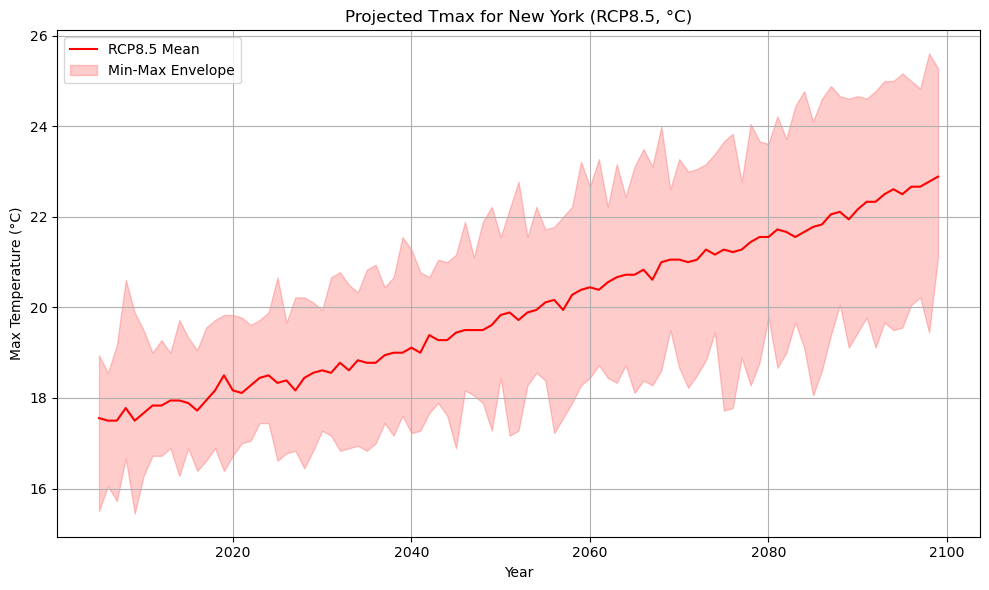

In [49]:
df_tmax_proj = pd.read_csv("New_York_County-annual-proj_mod-tmax_C.csv")
df_tmax_proj.columns = df_tmax_proj.columns.str.strip()

plt.figure(figsize=(10,6))
plt.plot(df_tmax_proj["year"], df_tmax_proj["rcp85_weighted_mean"], label="RCP8.5 Mean", color="red")
plt.fill_between(df_tmax_proj["year"], df_tmax_proj["rcp85_min"], df_tmax_proj["rcp85_max"], color='red', alpha=0.2, label="Min-Max Envelope")

plt.title("Projected Tmax for New York (RCP8.5, °C)")
plt.xlabel("Year")
plt.ylabel("Max Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


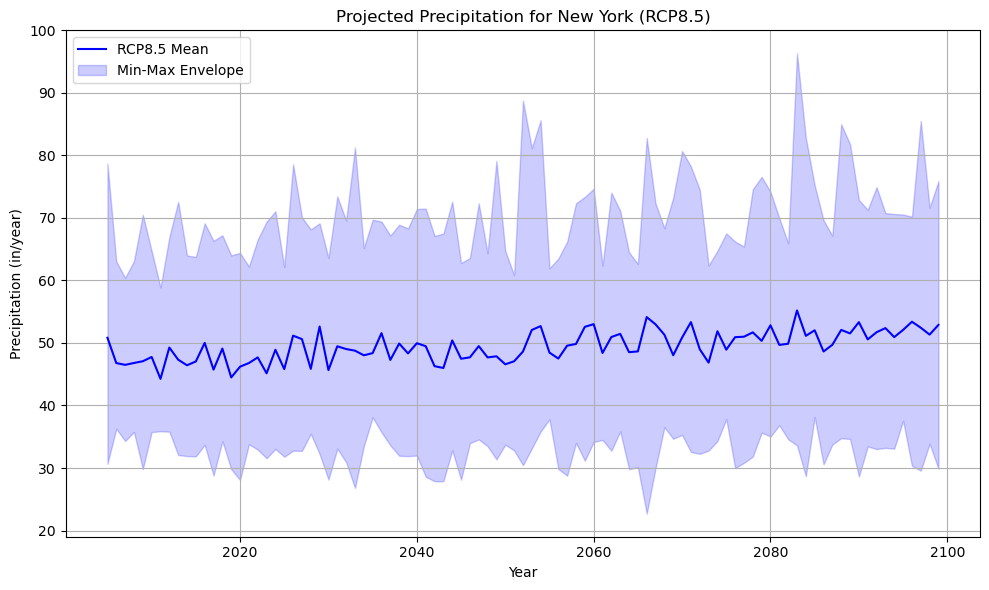

In [50]:
df_pcpn_proj = pd.read_csv("New_York_County-annual-proj_mod-pcpn.csv")
df_pcpn_proj.columns = df_pcpn_proj.columns.str.strip()

plt.figure(figsize=(10,6))
plt.plot(df_pcpn_proj["year"], df_pcpn_proj["rcp85_weighted_mean"], label="RCP8.5 Mean", color="blue")
plt.fill_between(df_pcpn_proj["year"], df_pcpn_proj["rcp85_min"], df_pcpn_proj["rcp85_max"], color='blue', alpha=0.2, label="Min-Max Envelope")

plt.title("Projected Precipitation for New York (RCP8.5)")
plt.xlabel("Year")
plt.ylabel("Precipitation (in/year)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [51]:
# Load files
obs = pd.read_csv("New_York_County-annual-hist_obs-tmax_C.csv")
mod = pd.read_csv("New_York_County-annual-hist_mod-tmax_C.csv")
gfdl = pd.read_csv("NYCHistoricalTASMAX_GFDL-CM4.csv")

# Standardize column names
obs.columns = ["year", "obs"]
mod = mod.iloc[:, :4]  # Keep only the first 4 columns
mod.columns = ["year", "mod_mean", "mod_min", "mod_max"]

gfdl.columns = ["year", "gfdl"]

# Merge on year
df_all = obs.merge(mod, on="year").merge(gfdl, on="year")

# Quick preview
display(df_all.head())


,year,obs,mod_mean,mod_min,mod_max,gfdl
0,1950,16.000000,16.500000,15.333333,17.777778,8.583923
1,1951,17.000000,16.833333,15.555556,17.833333,9.194519
2,1952,17.222222,16.555556,15.166667,18.222222,8.626953
3,1953,18.111111,16.555556,15.222222,17.611111,7.996460
4,1954,17.000000,16.388889,15.000000,18.722222,7.324341


In [52]:
!pip install scikit-learn


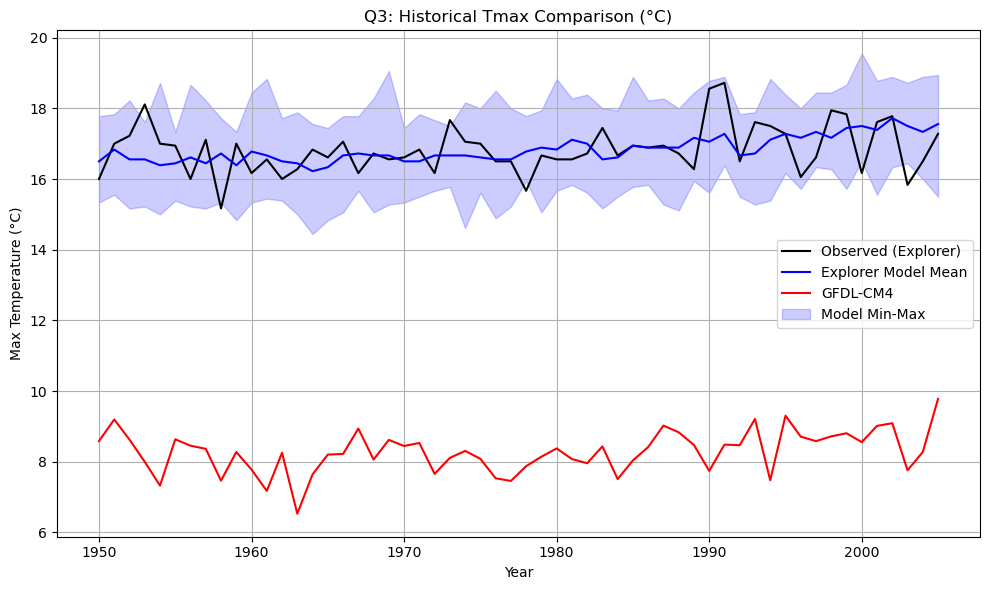

📊 RMSE (Observed vs Model Mean): 0.70 °C
📊 RMSE (Model Mean vs GFDL-CM4): 8.57 °C
📊 RMSE (Observed vs GFDL-CM4): 8.59 °C


In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# --- Plot ---
plt.figure(figsize=(10,6))

plt.plot(df_all["year"], df_all["obs"], label="Observed (Explorer)", color="black")
plt.plot(df_all["year"], df_all["mod_mean"], label="Explorer Model Mean", color="blue")
plt.plot(df_all["year"], df_all["gfdl"], label="GFDL-CM4", color="red")

# Model envelope
plt.fill_between(df_all["year"], df_all["mod_min"], df_all["mod_max"], color='blue', alpha=0.2, label="Model Min-Max")

plt.title("Q3: Historical Tmax Comparison (°C)")
plt.xlabel("Year")
plt.ylabel("Max Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- RMSE ---
rmse_obs_vs_mod = np.sqrt(mean_squared_error(df_all["obs"], df_all["mod_mean"]))
rmse_mod_vs_gfdl = np.sqrt(mean_squared_error(df_all["mod_mean"], df_all["gfdl"]))
rmse_obs_vs_gfdl = np.sqrt(mean_squared_error(df_all["obs"], df_all["gfdl"]))

print(f"📊 RMSE (Observed vs Model Mean): {rmse_obs_vs_mod:.2f} °C")
print(f"📊 RMSE (Model Mean vs GFDL-CM4): {rmse_mod_vs_gfdl:.2f} °C")
print(f"📊 RMSE (Observed vs GFDL-CM4): {rmse_obs_vs_gfdl:.2f} °C")


The GFDL-CM4 output underestimates observed Tmax by ~8°C. This is likely due to spatial averaging over large grid cells and the lack of urban heat island effects in global climate models. In contrast, the Explorer data reflects local conditions and ensemble model output specific to New York County.

In [57]:
import fsspec
import xarray as xr

model = 'GFDL-CM4'

zstore_hist = df_historical.query(f"source_id == '{model}'").zstore.values[0]
zstore_ssp585 = df_ssp585.query(f"source_id == '{model}'").zstore.values[0]

# 🔧 Use fsspec directly to enforce anonymous access
mapper_hist = fsspec.get_mapper(zstore_hist, anon=True)
mapper_ssp = fsspec.get_mapper(zstore_ssp585, anon=True)

# ✅ Load the Zarr datasets
ds_hist = xr.open_zarr(mapper_hist, consolidated=True)
ds_ssp585 = xr.open_zarr(mapper_ssp, consolidated=True)


In [61]:
print(df_ssp585.columns)


Index(['year', 'height', 'tas'], dtype='object')


In [63]:
df_ssp585 = ds_ssp585["tas"].sel(
    lat=slice(33.5, 32.5),
    lon=slice(360-97.5, 360-96.5)
).mean(dim=["lat", "lon"]).groupby("time.year").mean().to_dataframe().reset_index()

# Keep only necessary columns and copy safely
df_ssp585 = df_ssp585[["year", "tas"]].copy()

# Convert to Celsius
df_ssp585["tas"] = df_ssp585["tas"] - 273.15

# Rename column
df_ssp585.columns = ["year", "gfdl_ssp585"]


In [64]:
# Load Climate Explorer RCP8.5 projections
df_rcp = pd.read_csv("New_York_County-annual-proj_mod-tmax_C.csv")
df_rcp.columns = df_rcp.columns.str.strip()  # Clean any leading/trailing spaces

# Keep only RCP8.5 mean and year
df_rcp = df_rcp[["year", "rcp85_weighted_mean"]]


In [67]:
print(df_ssp585["year"].min(), df_ssp585["year"].max())
print(df_rcp["year"].min(), df_rcp["year"].max())


2015 2100
2005 2099


In [68]:
df_future = df_ssp585.merge(df_rcp, on="year", how="outer")


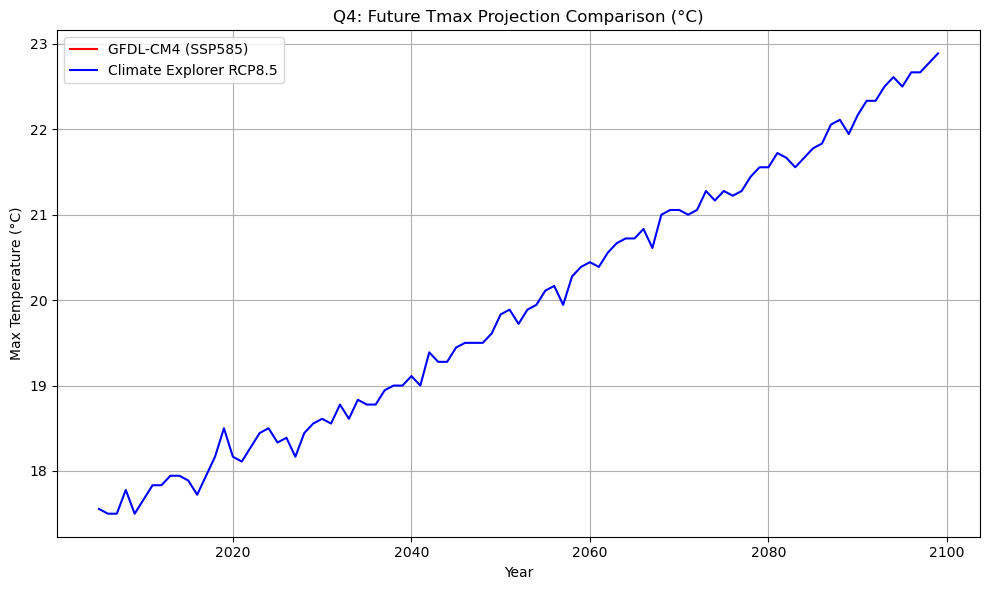

In [70]:
plt.figure(figsize=(10,6))
plt.plot(df_future["year"], df_future["gfdl_ssp585"], label="GFDL-CM4 (SSP585)", color="red")
plt.plot(df_future["year"], df_future["rcp85_weighted_mean"], label="Climate Explorer RCP8.5", color="blue")

plt.title("Q4: Future Tmax Projection Comparison (°C)")
plt.xlabel("Year")
plt.ylabel("Max Temperature (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [71]:
print(df_ssp585.head())
print(df_ssp585.columns)
print(df_ssp585.dtypes)


   year  gfdl_ssp585
0  2015          NaN
1  2016          NaN
2  2017          NaN
3  2018          NaN
4  2019          NaN
Index(['year', 'gfdl_ssp585'], dtype='object')
year             int64
gfdl_ssp585    float32
dtype: object


In [72]:
df_gfdl = pd.read_csv("NYCHistoricalTASMAX_GFDL-CM4.csv")
df_gfdl.columns = ["year", "gfdl_ssp585"]


In [73]:
print(df_gfdl.head())
print(df_gfdl.dtypes)


   year  gfdl_ssp585
0  1850     8.954041
1  1851     7.966187
2  1852     7.233063
3  1853     8.889832
4  1854     8.717133
year             int64
gfdl_ssp585    float64
dtype: object


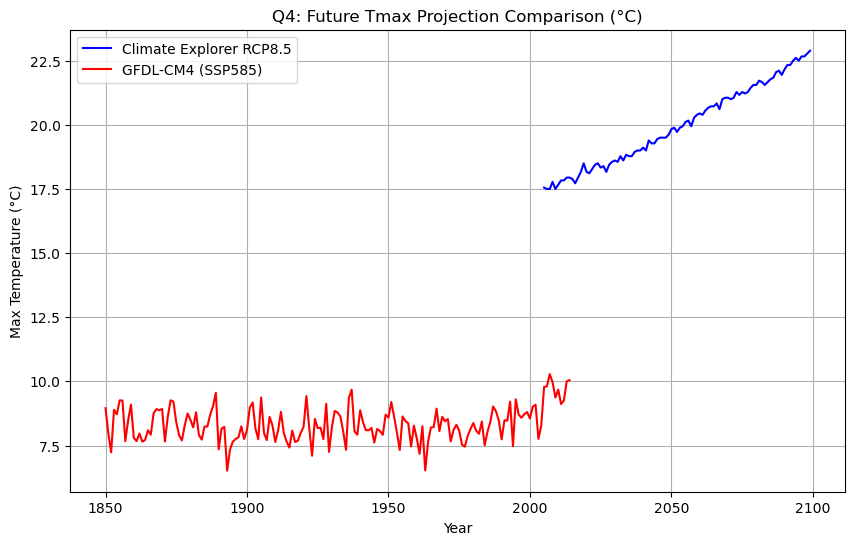

In [74]:
plt.figure(figsize=(10,6))
plt.plot(df_rcp["year"], df_rcp["rcp85_weighted_mean"], label="Climate Explorer RCP8.5", color="blue")
plt.plot(df_gfdl["year"], df_gfdl["gfdl_ssp585"], label="GFDL-CM4 (SSP585)", color="red")

plt.title("Q4: Future Tmax Projection Comparison (°C)")
plt.xlabel("Year")
plt.ylabel("Max Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()


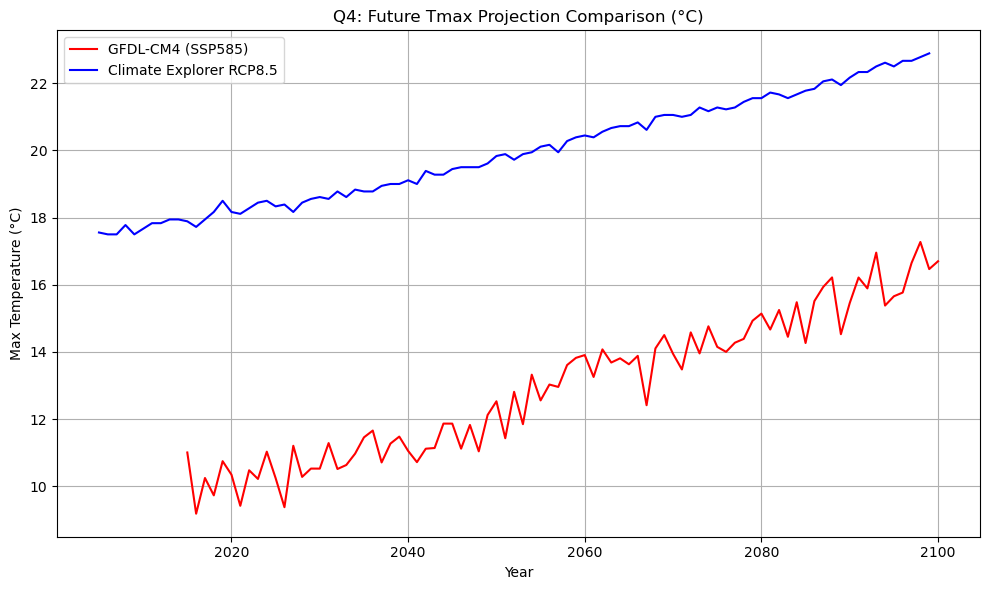

In [78]:
plt.figure(figsize=(10, 6))
plt.plot(futureDF.index, futureDF["tas"], label="GFDL-CM4 (SSP585)", color="red")
plt.plot(df_rcp["year"], df_rcp["rcp85_weighted_mean"], label="Climate Explorer RCP8.5", color="blue")
plt.xlabel("Year")
plt.ylabel("Max Temperature (°C)")
plt.title("Q4: Future Tmax Projection Comparison (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [80]:
import pandas as pd

# Load historical GFDL model data (tasmax, °C)
df_hist = pd.read_csv("NYCHistoricalTASMAX_GFDL-CM4.csv")
df_hist.columns = df_hist.columns.str.strip()
df_hist.columns = ["year", "tas"]

# Load future GFDL model data (tasmax, °C)
df_future = pd.read_csv("NYCFutureTASMAX_GFDL-CM4.csv")
df_future.columns = df_future.columns.str.strip()
df_future.columns = ["year", "tas"]

# --- Calculate 30-year averages ---
hist_avg = df_hist[df_hist["year"].between(1971, 2000)]["tas"].mean()
fut_avg = df_future[df_future["year"].between(2071, 2100)]["tas"].mean()

# --- Compute projected change ---
change = fut_avg - hist_avg

# --- Output results ---
print(f"📊 Historical Avg (1971–2000): {hist_avg:.2f} °C")
print(f"📈 Future Avg (2071–2100): {fut_avg:.2f} °C")
print(f"🔺 Projected Tmax Change: {change:.2f} °C")


📊 Historical Avg (1971–2000): 8.30 °C
📈 Future Avg (2071–2100): 15.28 °C
🔺 Projected Tmax Change: 6.98 °C
